 # <center> PROJET NLP ENSAE 2020 - TOXIC COMMENT CLASSIFICATION </center> 
<center> Eléonore BLANCHARD, Yannick LY </center>

---

## <u> **Description du sujet** </u>

<h5 align='justify'>Avec la forte montée des réseaux sociaux et de par l'anonymat d'internet, nous observons une hausse de commentaires toxiques et du harcèlement en ligne. Certains d'entre eux étant même illégaux du fait de leur caractère raciste, homophobe, pédophile, etc. C'est pourquoi il est important que les plateformes en ligne modèrent ce type de commentaires et appliquent des sanctions comme le bannissement de la plateforme ou encore transmission de l'adresse IP aux autorités compétentes. Cependant les plateformes en ligne ont encore du mal à identifier correctement ces commentaires notamment son type de toxicité (toxique, très toxique, obscène, menace, insulte, haine identitaire). Pouvoir identifier le type de toxicité permettrait alors de pouvoir appliquer des mesures adéquates. Nous cherchons alors à construire un modèle multi-label permettant de détecter le type ou les types de toxicité. Nous utiliserons un data set issu de commentaires provenant de Wikipédia.</h5>







##  **<u>0 - Introduction</u>** 

à rédiger au propre

In [0]:
# Basics
import numpy as np
import pandas as pd

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# NLP
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TreebankWordTokenizer, ToktokTokenizer, TweetTokenizer, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from string import punctuation

# Tools
from functools import reduce
from operator import add
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

#from gensim.models import LdaModel
#from gensim import corpora
#import pyLDAvis.gensim

### **<u>0 - Téléchargement du set de données et des packages</u>**

In [21]:
!wget -c https://github.com/YannickLy/NLP-Project-ENSAE-2020/blob/master/Data/Data.zip?raw=true -O Data.zip
!unzip Data.zip

--2020-04-12 14:28:57--  https://github.com/YannickLy/NLP-Project-ENSAE-2020/blob/master/Data/Data.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/YannickLy/NLP-Project-ENSAE-2020/raw/master/Data/Data.zip [following]
--2020-04-12 14:28:57--  https://github.com/YannickLy/NLP-Project-ENSAE-2020/raw/master/Data/Data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YannickLy/NLP-Project-ENSAE-2020/master/Data/Data.zip [following]
--2020-04-12 14:28:57--  https://raw.githubusercontent.com/YannickLy/NLP-Project-ENSAE-2020/master/Data/Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### **<u>0 - Description du set de données</u>**

In [23]:
train = pd.read_csv('Data/train.csv')
X_train = train[['id', 'comment_text']]
y_train = train[['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

X_test = pd.read_csv('Data/test.csv')
y_test = pd.read_csv('Data/test_labels.csv')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Le data set est composé de 8 colonnes :
* `id`: ID unique afin d'identifier le commentaire
* `comment_text` : le texte du commentaire
* `toxic` : le commentaire comporte t-il un caractère toxique ? (1 si oui, 0 si non)
* `severe_toxic` : le commentaire comporte t-il un caractère très toxique ? (1 si oui, 0 si non)
* `obscene` : le commentaire comporte t-il un caractère obscène ? (1 si oui, 0 si non)
* `threat` : le commentaire comporte t-il une menace ? (1 si oui, 0 si non)
* `insult` : le commentaire comporte t-il une insulte ? (1 si oui, 0 si non)
* `identity_hate` : le commentaire comporte t-il un caractère de haine identitaire ? (1 si oui, 0 si non)

Le data set est composé de 159 171 commentaires qui ont été labellisés par des humains, des erreurs de labellisations sont alors possibles. Certains commentaires disposent de plusieurs labels.

Afin de mieux comprendre ce que chaque label (`toxic`, `severe_toxic`, `obscene`,  `threat`, `insult`, `identity_hate`) signifie, nous allons afficher un exemple pour chacun :

<u>Toxic comment :</u>

In [0]:
print(train[(train.toxic==1) & (train.severe_toxic==0) & (train.obscene==0) & (train.threat==0) & (train.insult==0) & (train.identity_hate==0)].iloc[0,1])

Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


<u>Severe toxic comment :</u> 

In [0]:
print(train[(train.toxic==1) & (train.severe_toxic==1) & (train.obscene==0) & (train.threat==0) & (train.insult==0) & (train.identity_hate==0)].iloc[0,1])

so everytime i reset my modem my ip changes

fuck you petty sexless ugly ass desperate no life.. no status in society anal retentive wiki admins

(the site is great.. but the lower level admins have no life and can't handle the little authority they have.. it tells you how small and pathetic their lives are)

if i get blocked ill be on in 20 seconds with a new ip or the pizza is free.

cheers.


<u> Obscene comment : </u>

In [0]:
print(train[(train.toxic==0) & (train.severe_toxic==0) & (train.obscene==1) & (train.threat==0) & (train.insult==0) & (train.identity_hate==0)].iloc[0,1])

How do you know he is dead.  Its just his plane that crashed.  Jeezz, quit busting his nuts, folks.


<u> Threat comment : </u>

In [0]:
print(train[(train.toxic==0) & (train.severe_toxic==0) & (train.obscene==0) & (train.threat==1) & (train.insult==0) & (train.identity_hate==0)].iloc[0,1])

Please stop. If you continue to ignore our policies by introducing inappropriate pages to Wikipedia, you will be blocked.


<u> Insult comment : </u>

In [0]:
print(train[(train.toxic==0) & (train.severe_toxic==0) & (train.obscene==0) & (train.threat==0) & (train.insult==1) & (train.identity_hate==0)].iloc[0,1])

REPLY ABOVE:
That was me, loser. The UN defines Vietnam to be part of Southeast Asia. And far as I know Vietnam is part of ASEAN, and used to be part of French Indochina with Laos and all those shit countries Anyway your culture has always been more influenced by SEA than Han Chinese (as in proper Yangtze Han Chinese, not the fringe indigenous tribes in Guangzhou/Guangxi). 

Just admit that you vietnamese are all a bunch of wannabe crap people. ALL the east asian people I've spoken to thinks of Vietnam as a very integral part of SEA, and we all think you're backward, dirty and speak in a horrible swearing language. Doesn't matter what crap you spout on Wikipedia, won't change the way people in the real world think.


<u> Identity hate comment : </u>

In [0]:
print(train[(train.toxic==0) & (train.severe_toxic==0) & (train.obscene==0) & (train.threat==0) & (train.insult==0) & (train.identity_hate==1)].iloc[0,1])

Mate, sound like you are jewish

Gayness is in the air


## **<u>I - Statistiques exploratoires et analyse des commentaires</u>**

à rédiger au propre

### **<u>I.1 Présentation des données</u>**

In [0]:
nrow = train.shape[0]
nclass = y_train.shape[1]-1

#### <u>Equilibre des classes</u>

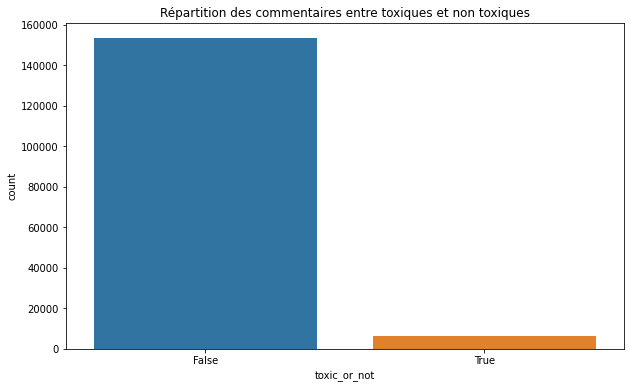

In [25]:
rowsums = train.iloc[:,2:].sum(axis=1)
train['toxic_or_not'] = (rowsums==1) # True si le commentaire est toxique False sinon

plt.figure(figsize=(10,6))
ax = sns.countplot(data = train, x = 'toxic_or_not')
plt.title("Répartition des commentaires entre toxiques et non toxiques")
rects = ax.patches

On remarque qu'il y a beaucoup plus de commentaires non toxiques que toxiques (~150k versus ~16k). Cela pose un premier problème de déséquilibre entre les classes. Il sera important de prendre en compte cette répartition lors du choix de l'algorithme de classification.

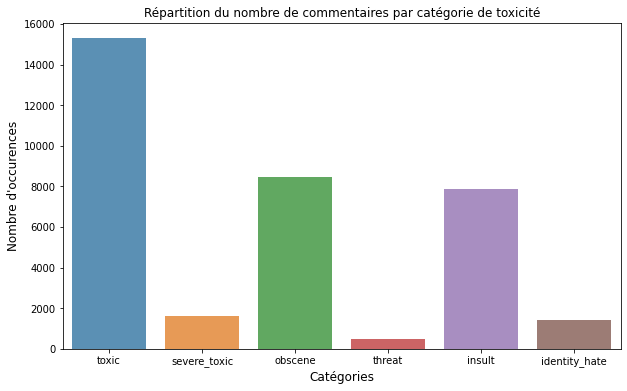

In [26]:
cat = y_train.iloc[:,1:].sum()

plt.figure(figsize=(10,6))
ax = sns.barplot(cat.index, cat.values, alpha=0.8)
plt.title("Répartition du nombre de commentaires par catégorie de toxicité")
plt.ylabel("Nombre d'occurences", fontsize=12)
plt.xlabel("Catégories", fontsize=12)
rects = ax.patches

Egalement, nous observons un déséquilibre parmi les types de toxicités (par exemple, il y a beaucoup moins de commentaires "threat" ou "severe toxic" que de commentaire "toxic" ou "obscene").

Nous observons enfin qu'il y a ~16k de commentaires toxiques mais que la somme des répartition du nombre de commentaires par catégorie de toxicité s'élève à ~35k, cela est seulement possible lorsqu'un commentaire est assimilé à plusieurs classes.

#### <u>Multi-label classification</u>

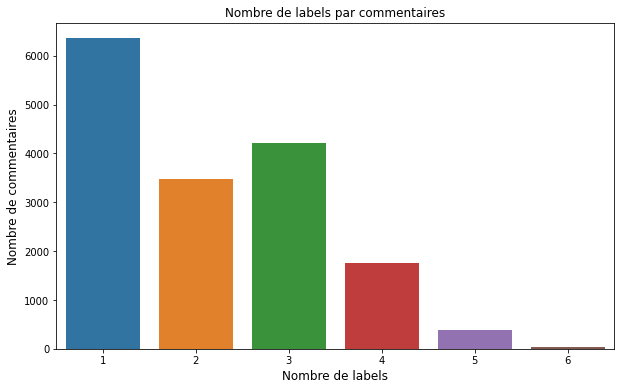

In [27]:
multi_label = y_train.iloc[:,1:].sum(axis=1).value_counts()

plt.figure(figsize=(10,6))
ax = sns.barplot(multi_label.index[1:], multi_label.values[1:])
plt.title("Nombre de labels par commentaires")
plt.xlabel("Nombre de labels", fontsize=12)
plt.ylabel("Nombre de commentaires", fontsize=12)
rects = ax.patches

### **<u>I.2 Analyse des commmentaires</u>**

<h5 align='justify'>Dans cette partie nous avons décidé de ne pas encore tokenizer et cleaner les commentaires car nous souhaitons exploiter toute l'information présente dans les commentaires incluant le nombre de stopwords, le nombre de caractère majuscule etc. Nous exploiterons ces données afin de créer de nouvelles variables si elles semblent pertinentes pour notre modèle de classification. Ces nouvelles variables compenseront la perte de données lorsque nous appliquerons notre fonction de cleanage. </h5>

In [0]:
eng_stopwords = set(stopwords.words('english'))
eng_stopwords.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])

df = pd.DataFrame()
df['toxic_or_not'] = train['toxic_or_not']

# Longueur d'un commentaire
df['count_paraph'] = train["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1) # on compte le nombre de paragraphes dans un commentaire
df['count_word']= train["comment_text"].apply(lambda x: len(str(x).split())) # on compte le nombre de mots dans un commentaire

# Aggressivité d'un commentaire
df['count_punctuations'] = train["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation])) # on compte le nombre de ponctuations dans un commentaire
df['count_words_upper'] = train["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()])) # on compte le nombre de mots en majuscule dans un commentaire
df['propor_punctuations'] = df['count_punctuations'] / df['count_word'] 
df['propor_words_upper'] = df['count_words_upper'] / df['count_word']

# Richesse du champs lexical d'un commentaire
df['count_stopwords'] = train["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords])) # on compte le nombre de stopwords dans un commentaire
df['count_unique_word'] = train["comment_text"].apply(lambda x: len(set(str(x).split()))) # on compte le nombre de mots uniques dans un commentaire

#### <u> Commentaires toxiques VS. Commentaires non toxiques </u>

Dans cette sous-partie nous souhaitons effectuer une analyse grossière des commentaires afin de déterminer si tout d'abord un commentaire est toxique ou non selon différents critères : longueur, aggressivité et richesse du champs lexical.

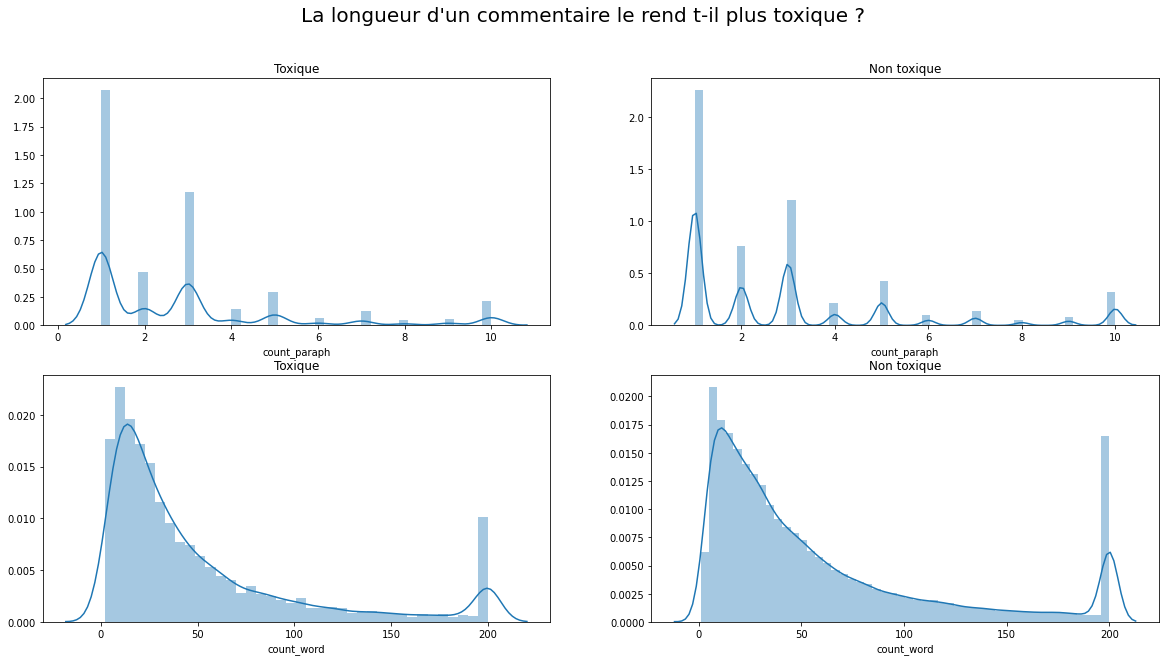

In [105]:
df['count_paraph'].loc[df['count_paraph']>10] = 10
df['count_word'].loc[df['count_word']>200] = 200

plt.figure(figsize=(20,10))
plt.suptitle("La longueur d'un commentaire le rend t-il plus toxique ?", fontsize = 20)
plt.subplot(221)
plt.title('Toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == True]['count_paraph'])
plt.subplot(222)
plt.title('Non toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == False]['count_paraph'])
plt.subplot(223)
plt.title('Toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == True]['count_word'])
plt.subplot(224)
plt.title('Non toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == False]['count_word'])
plt.show()

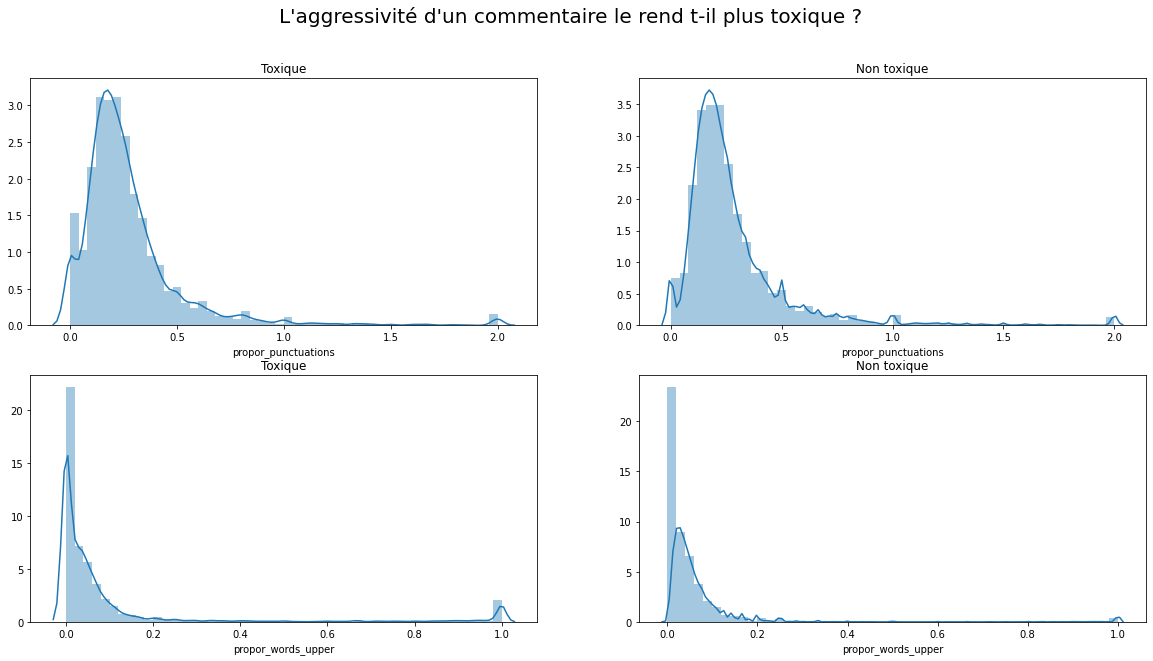

In [106]:
df['propor_punctuations'].loc[df['propor_punctuations']>2] = 2

plt.figure(figsize=(20,10))
plt.suptitle("L'aggressivité d'un commentaire le rend t-il plus toxique ?", fontsize = 20)
plt.subplot(221)
plt.title('Toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == True]['propor_punctuations'])
plt.subplot(222)
plt.title('Non toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == False]['propor_punctuations'])
plt.subplot(223)
plt.title('Toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == True]['propor_words_upper'])
plt.subplot(224)
plt.title('Non toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == False]['propor_words_upper'])
plt.show()

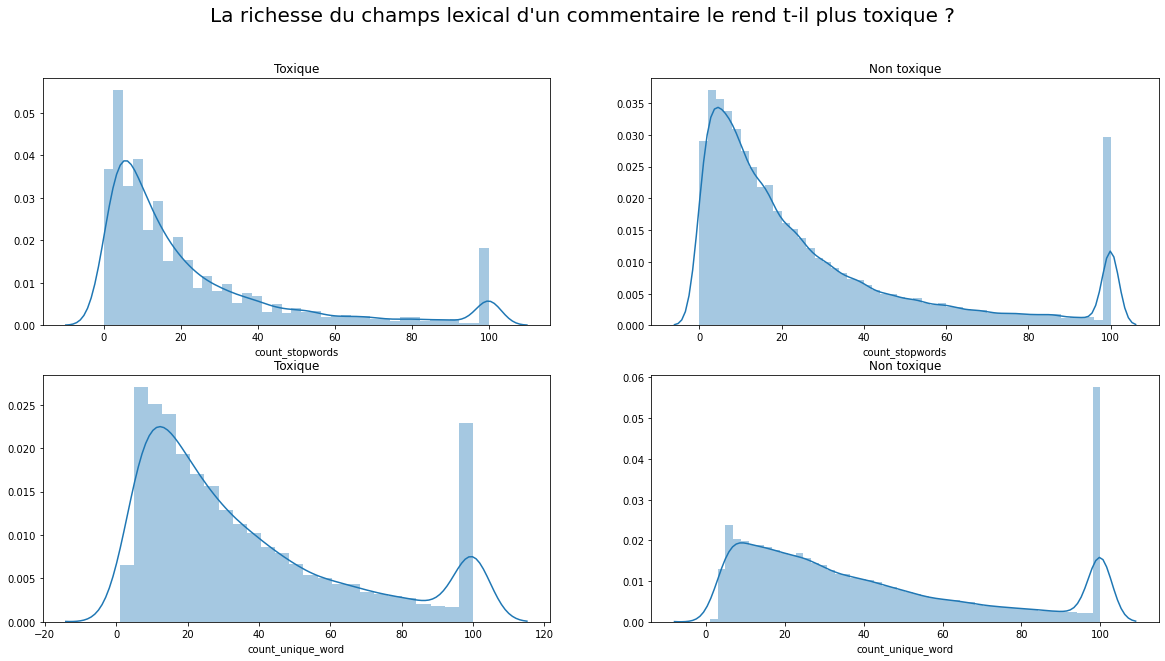

In [107]:
df['count_stopwords'].loc[df['count_stopwords']>100] = 100
df['count_unique_word'].loc[df['count_unique_word']>100] = 100

plt.figure(figsize=(20,10))
plt.suptitle("La richesse du champs lexical d'un commentaire le rend t-il plus toxique ?", fontsize = 20)
plt.subplot(221)
plt.title('Toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == True]['count_stopwords'])
plt.subplot(222)
plt.title('Non toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == False]['count_stopwords'])
plt.subplot(223)
plt.title('Toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == True]['count_unique_word'])
plt.subplot(224)
plt.title('Non toxique', fontsize = 12)
sns.distplot(df[df['toxic_or_not'] == False]['count_unique_word'])
plt.show()

Nous observons que l'aggressivité (nombre de ponctuations et de mots en majuscule) et la richesse du champs lexical (nombre de mots uniques et de stopwords) ont un impact significatif sur la détermination de la toxicité d'un commentaire ou non. 

Ces variables nous semblent être efficaces dans la classification de la toxicité d'un commentaire. En revanche cela ne semble pas être le cas pour la longueur d'un commentaire, nous décidons toute de fois de pousser l'analyse des variables qui la caractérisent (nombre de paragraphes et de mots).

#### <u> Comparaison entre les classes de toxicité sur la longueur de leur commentaire </u>

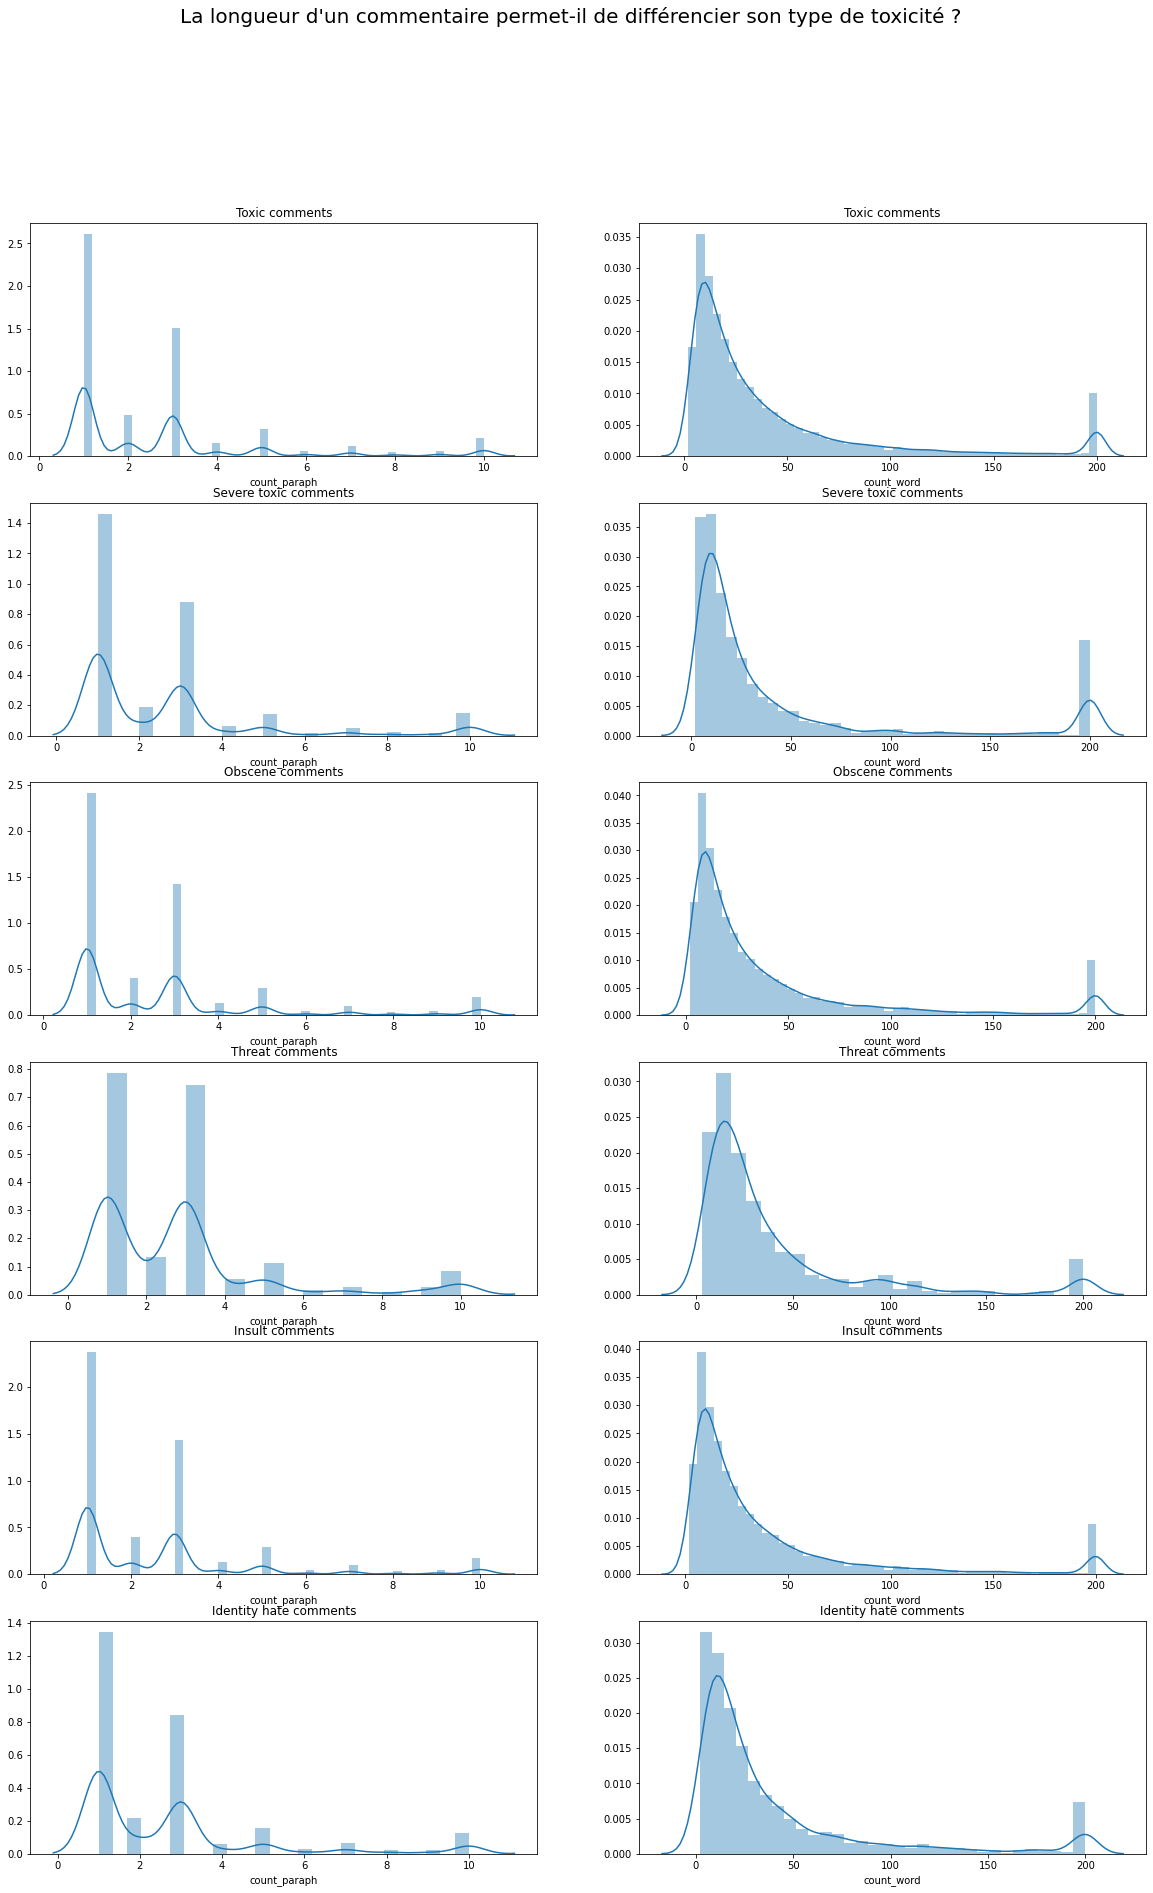

In [108]:
plt.figure(figsize=(20,30))
plt.suptitle("La longueur d'un commentaire permet-il de différencier son type de toxicité ?", fontsize = 20)
plt.subplot(621)
plt.title('Toxic comments', fontsize = 12)
sns.distplot(df[train['toxic']==1]['count_paraph'])
plt.subplot(622)
plt.title('Toxic comments', fontsize = 12)
sns.distplot(df[train['toxic']==1]['count_word'])
plt.subplot(623)
plt.title('Severe toxic comments', fontsize = 12)
sns.distplot(df[train['severe_toxic']==1]['count_paraph'])
plt.subplot(624)
plt.title('Severe toxic comments', fontsize = 12)
sns.distplot(df[train['severe_toxic']==1]['count_word'])
plt.subplot(625)
plt.title('Obscene comments', fontsize = 12)
sns.distplot(df[train['obscene']==1]['count_paraph'])
plt.subplot(626)
plt.title('Obscene comments', fontsize = 12)
sns.distplot(df[train['obscene']==1]['count_word'])
plt.subplot(627)
plt.title('Threat comments', fontsize = 12)
sns.distplot(df[train['threat']==1]['count_paraph'])
plt.subplot(628)
plt.title('Threat comments', fontsize = 12)
sns.distplot(df[train['threat']==1]['count_word'])
plt.subplot(629)
plt.title('Insult comments', fontsize = 12)
sns.distplot(df[train['insult']==1]['count_paraph'])
plt.subplot(6,2,10)
plt.title('Insult comments', fontsize = 12)
sns.distplot(df[train['insult']==1]['count_word'])
plt.subplot(6,2,11)
plt.title('Identity hate comments', fontsize = 12)
sns.distplot(df[train['identity_hate']==1]['count_paraph'])
plt.subplot(6,2,12)
plt.title('Identity hate comments', fontsize = 12)
sns.distplot(df[train['identity_hate']==1]['count_word'])
plt.show()

## **<u> II - Word-level preprocessing and cleaning</u>**

à rédiger au propre 

**Tokenization** : Séparation des commentaires en listes de mots en utilisant trois tokenizers différents

In [0]:
tokenizers = [TreebankWordTokenizer(), ToktokTokenizer(), TweetTokenizer()]

for tok in tokenizers:
    arr = train.comment_text.apply(lambda x: tok.tokenize(x)).array
    arr = reduce(add, arr)
    print("Taille du vocabulaire : {0}, avec le tokenizer {1}".format(len(set(arr)), tok))  

Taille du vocabulaire : 12925, avec le tokenizer <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x0000024FDB86C588>
Taille du vocabulaire : 12827, avec le tokenizer <nltk.tokenize.toktok.ToktokTokenizer object at 0x0000024FDB8603C8>
Taille du vocabulaire : 11904, avec le tokenizer <nltk.tokenize.casual.TweetTokenizer object at 0x0000024FDB85D3C8>


### **<u>II.3 WordCloud</u>**

**Toxic comments :**

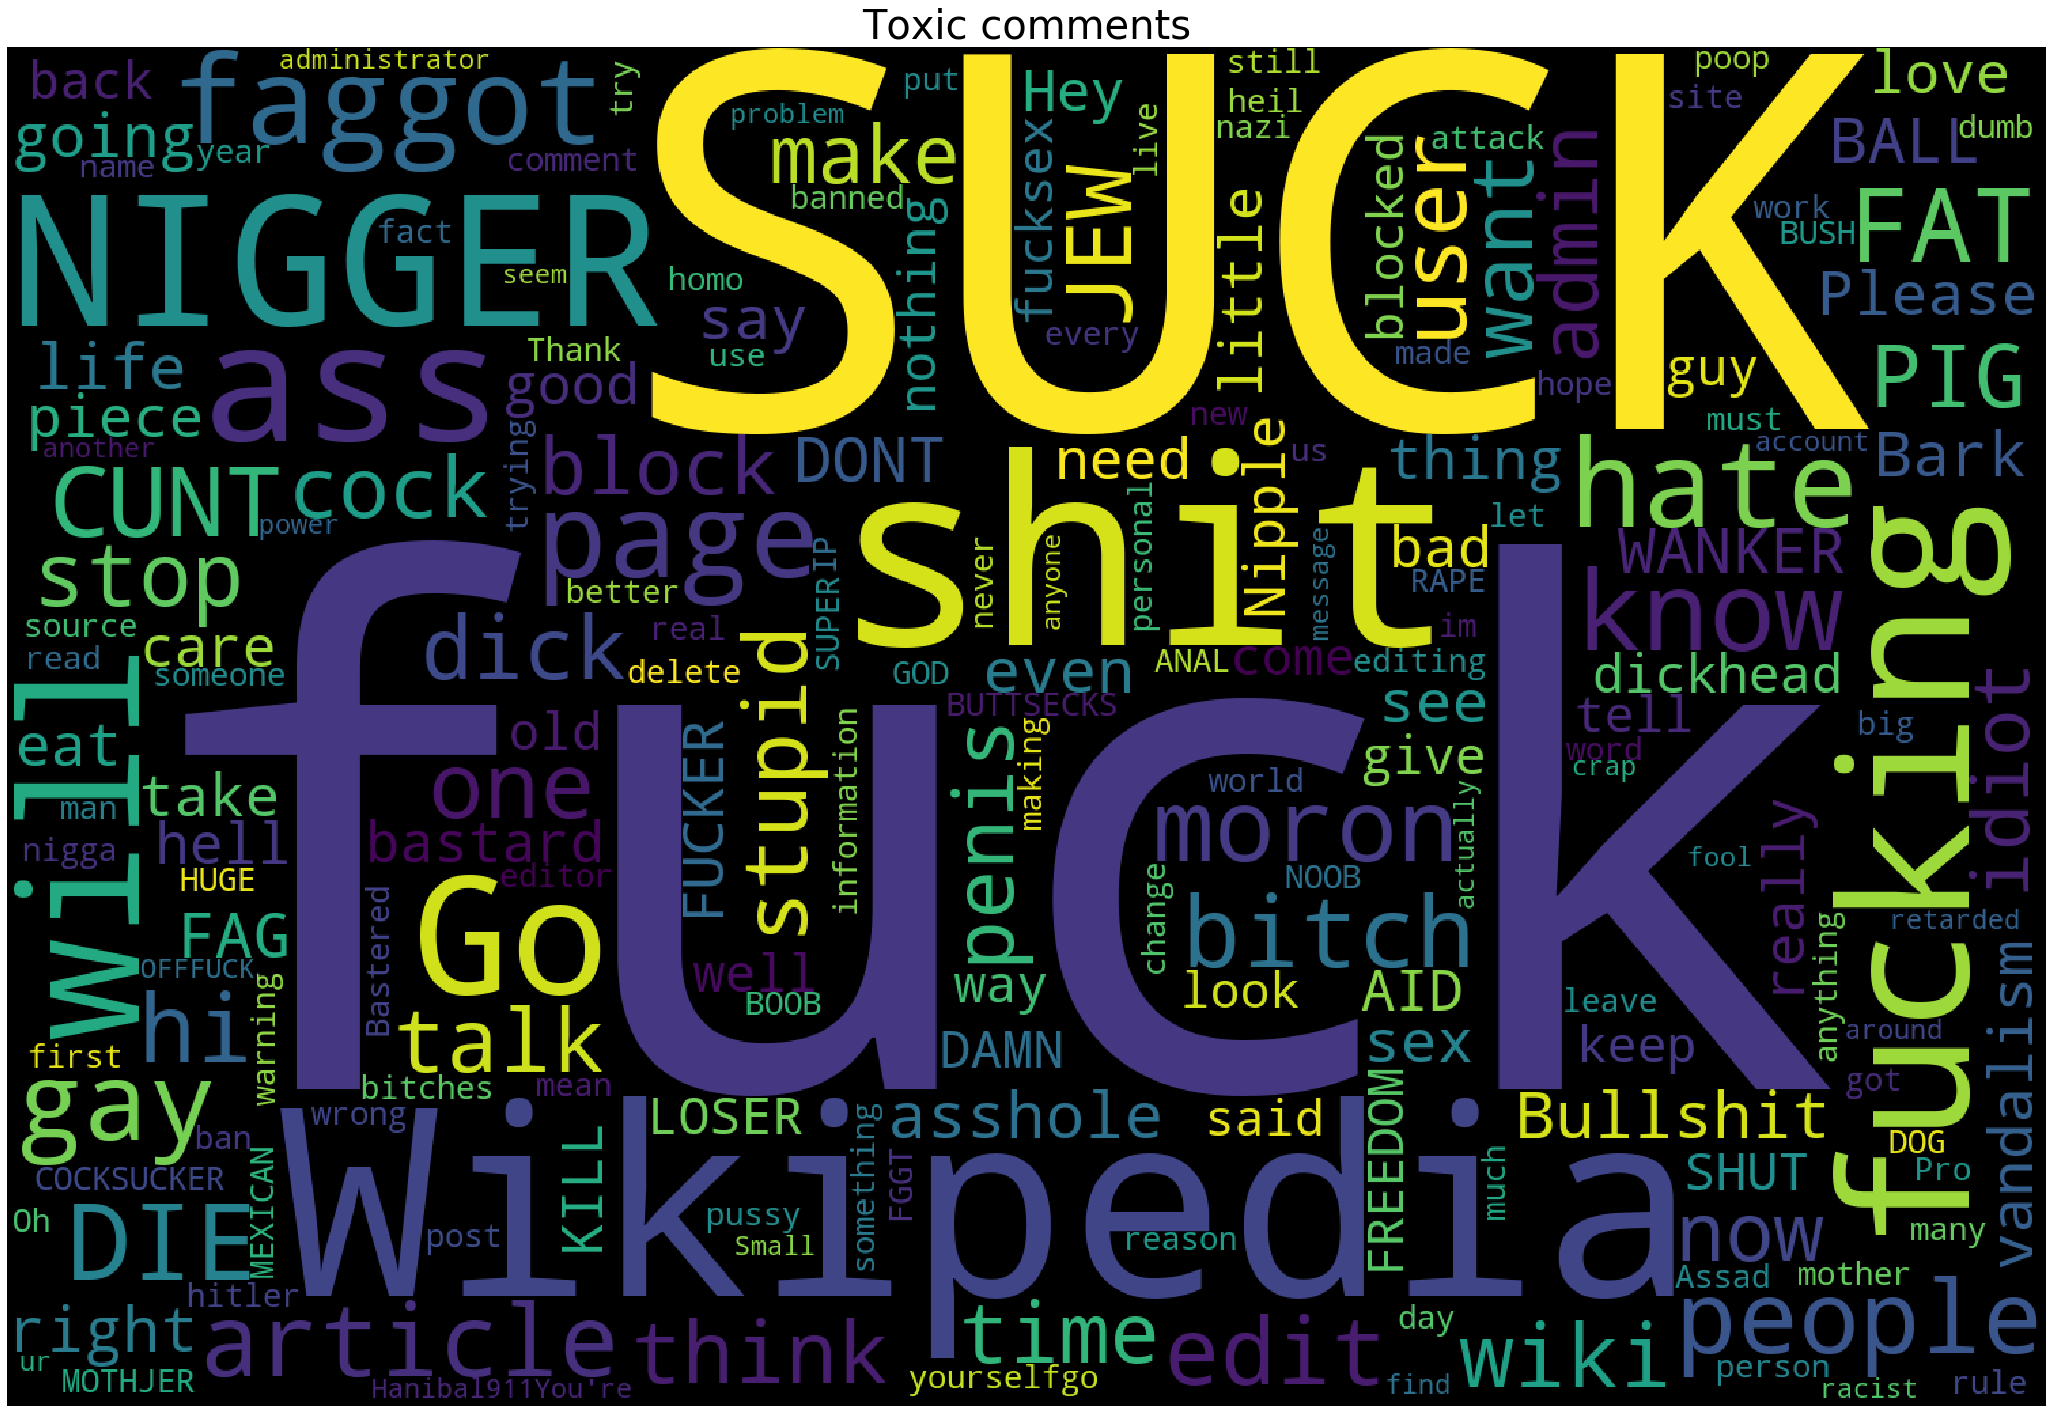

In [0]:
plt.figure(figsize=(40,25))
subset = train.where(train['toxic']==1).dropna()
text = subset['comment_text'].values
cloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', collocations = False, width = 1500, height = 1000).generate(" ".join(text))
plt.axis('off')
plt.title('Toxic comments', fontsize = 40)
plt.imshow(cloud)

**Severe toxic comments :**

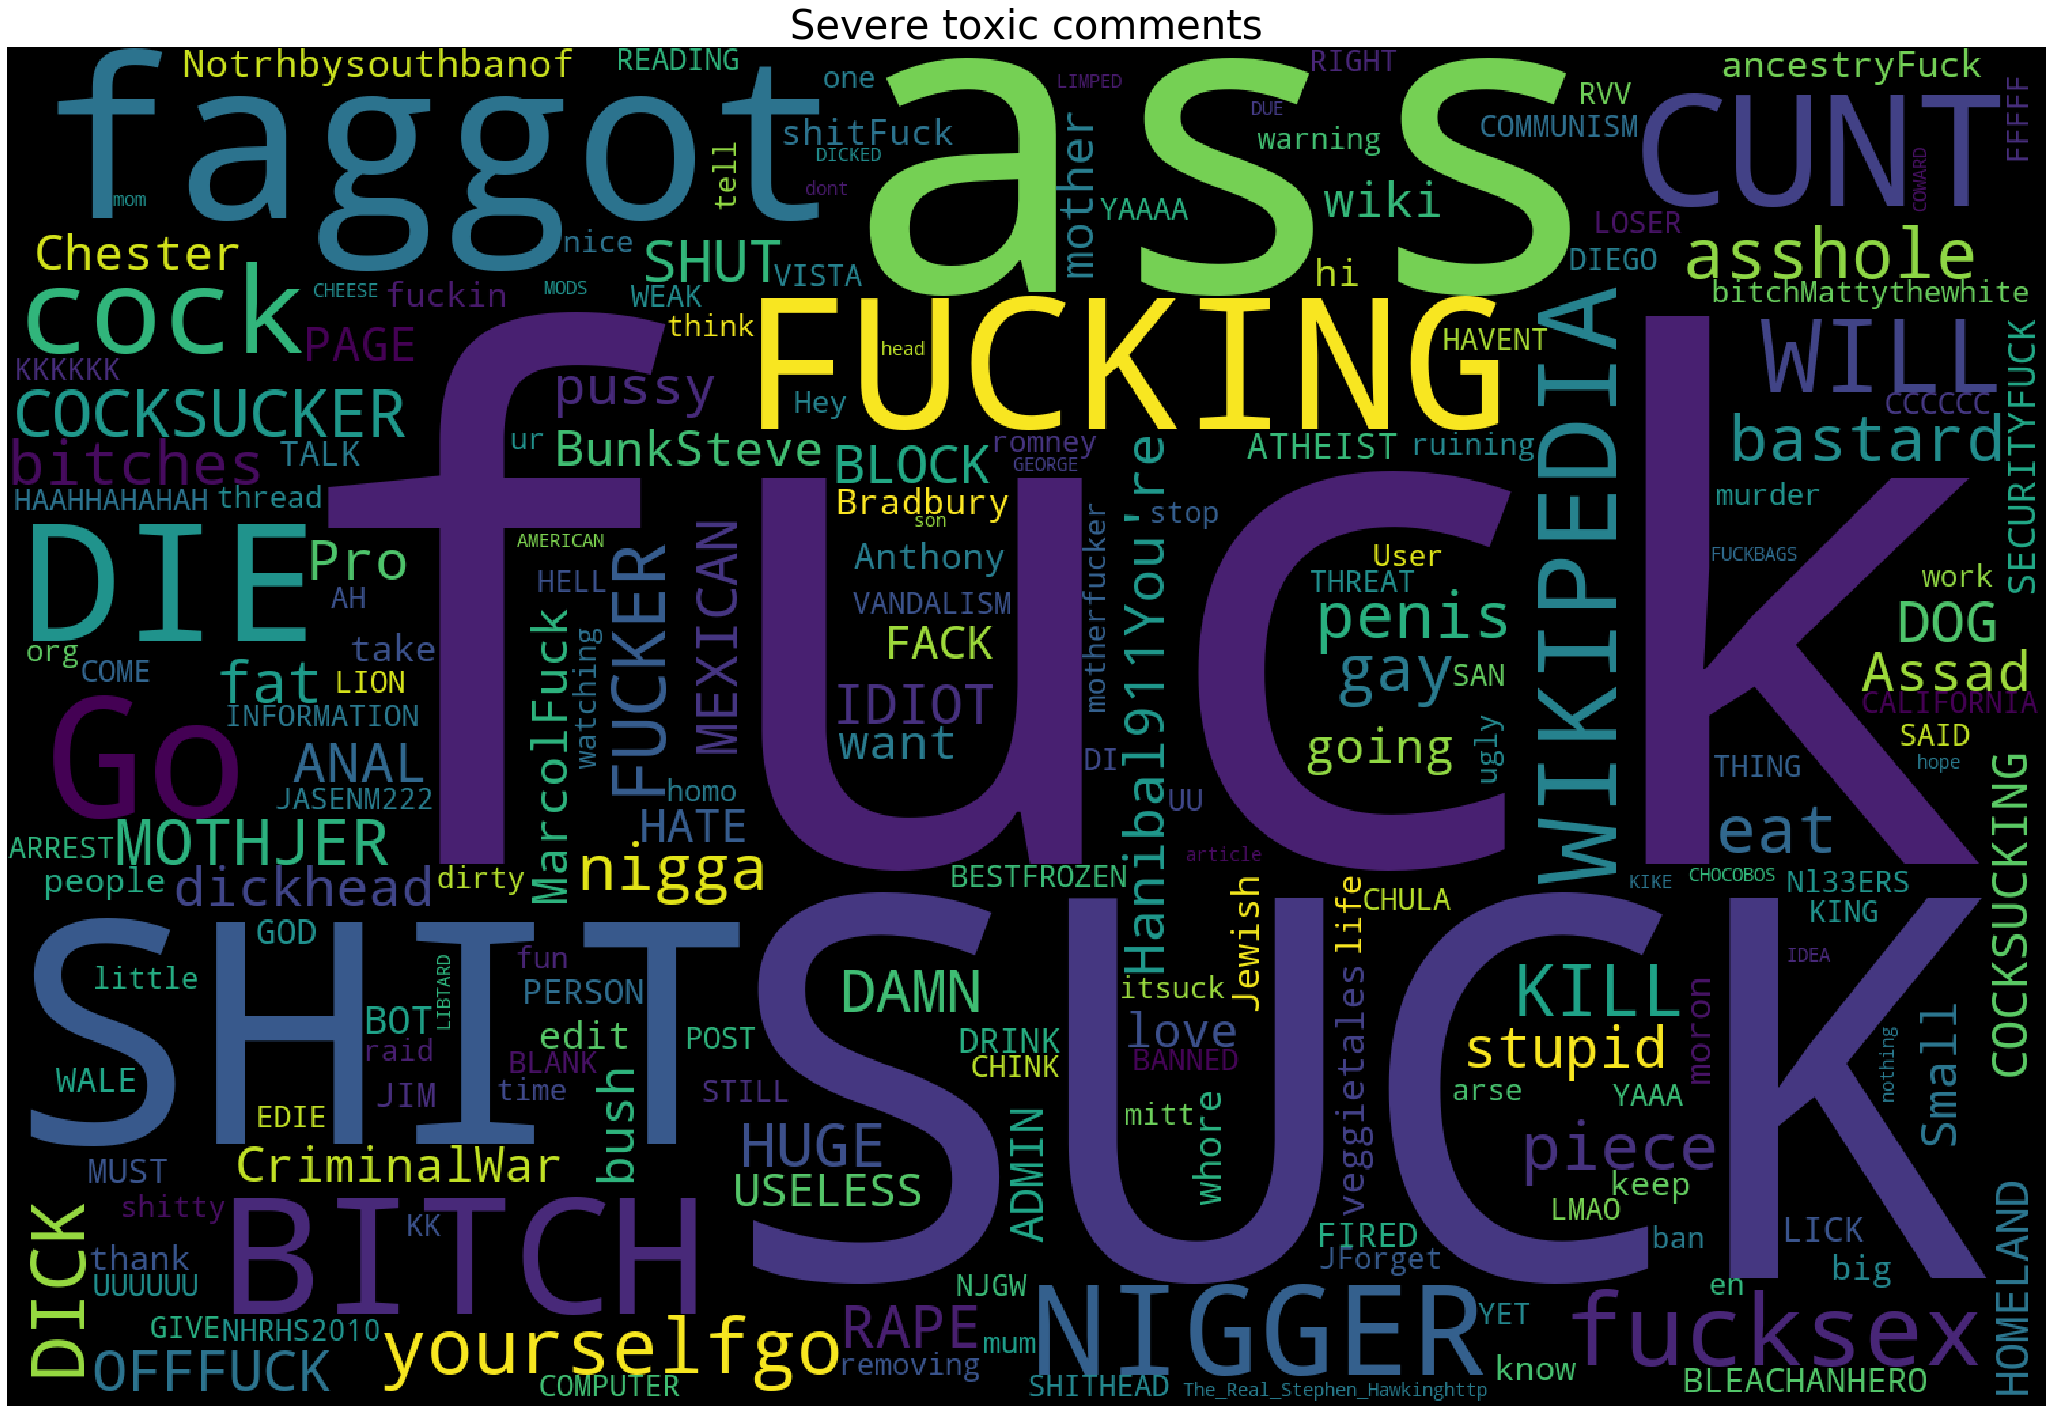

In [0]:
plt.figure(figsize=(40,25))
subset = train.where(train['severe_toxic']==1).dropna()
text = subset['comment_text'].values
cloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', collocations = False, width = 1500, height = 1000).generate(" ".join(text))
plt.axis('off')
plt.title('Severe toxic comments', fontsize = 40)
plt.imshow(cloud)

**Obscene comments :**

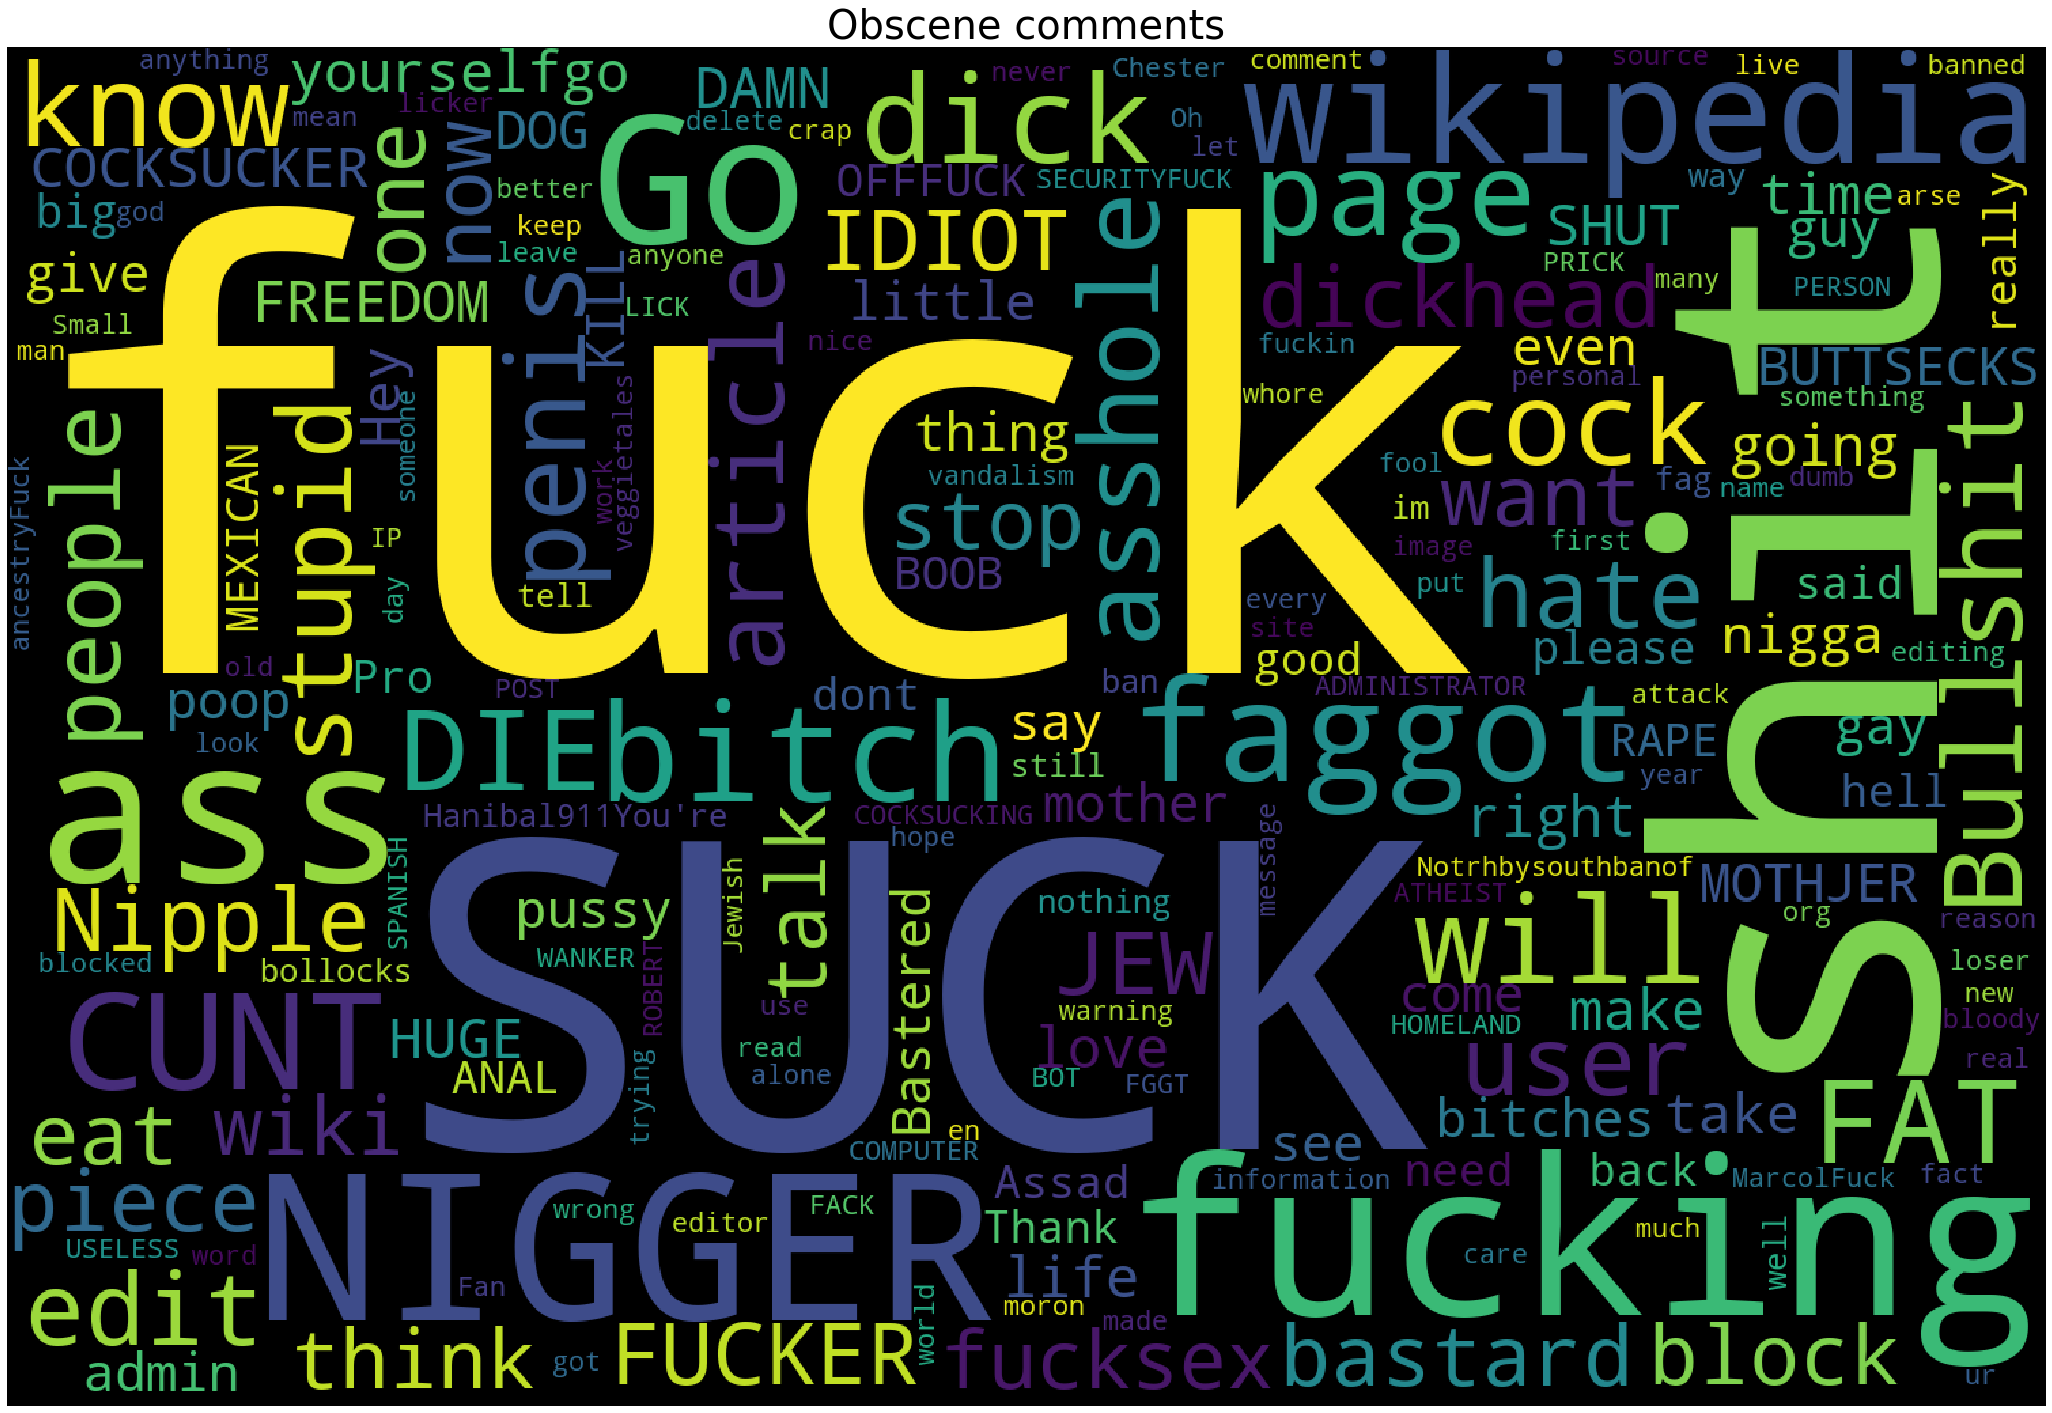

In [0]:
plt.figure(figsize=(40,25))
subset = train.where(train['obscene']==1).dropna()
text = subset['comment_text'].values
cloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', collocations = False, width = 1500, height = 1000).generate(" ".join(text))
plt.axis('off')
plt.title('Obscene comments', fontsize = 40)
plt.imshow(cloud)

**Threat comments :**

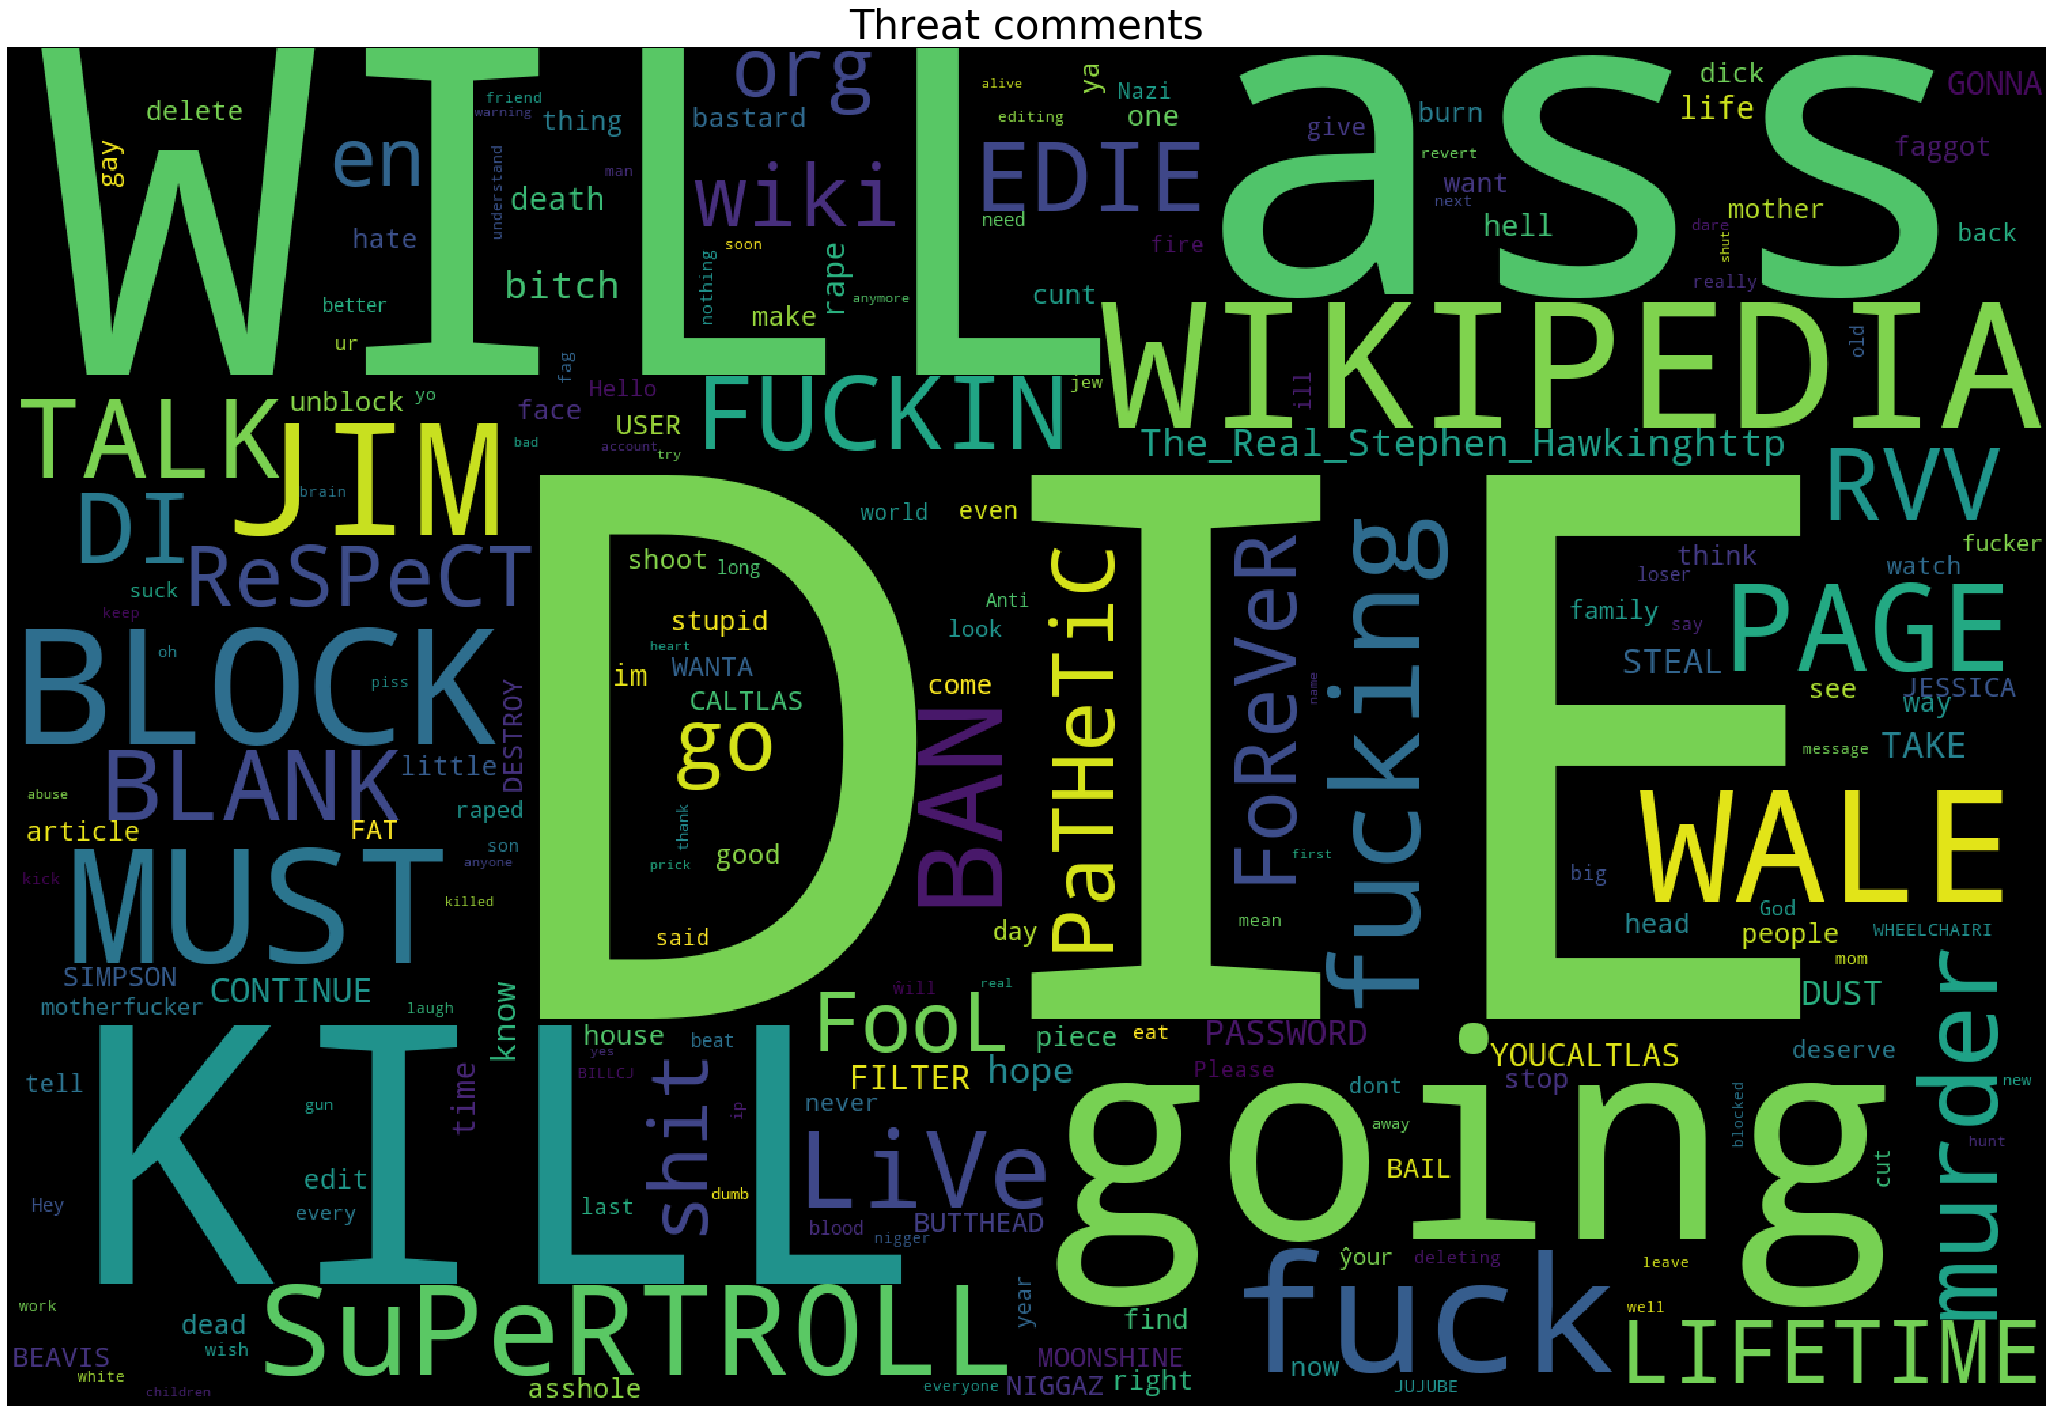

In [0]:
plt.figure(figsize=(40,25))
subset = train.where(train['threat']==1).dropna()
text = subset['comment_text'].values
cloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', collocations = False, width = 1500, height = 1000).generate(" ".join(text))
plt.axis('off')
plt.title('Threat comments', fontsize = 40)
plt.imshow(cloud)

**Insult comments :**

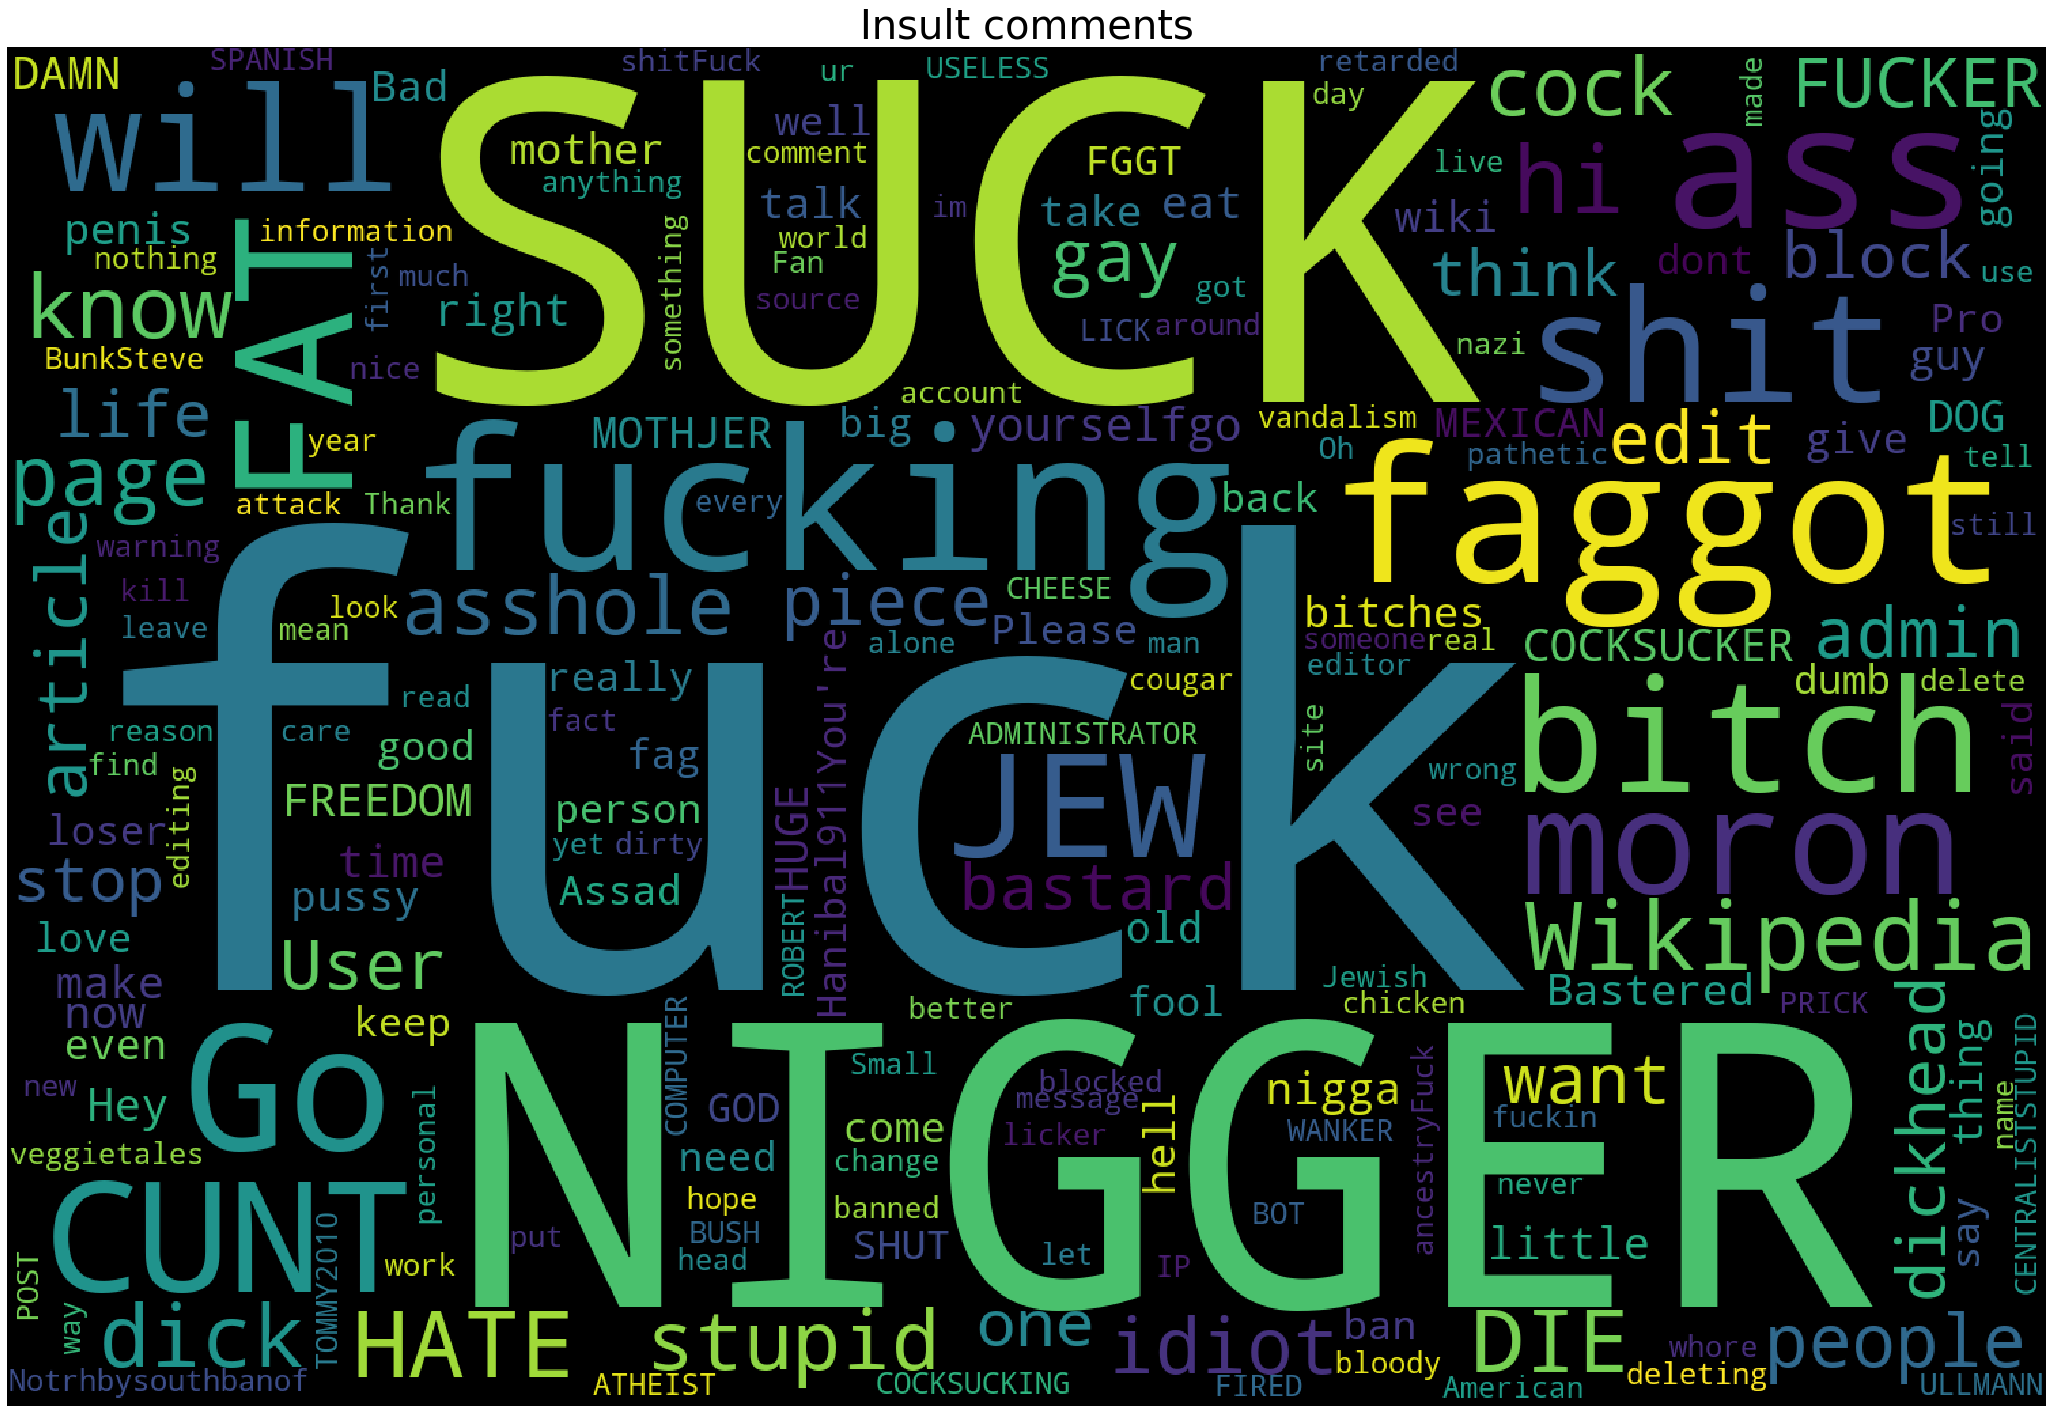

In [0]:
plt.figure(figsize=(40,25))
subset = train.where(train['insult']==1).dropna()
text = subset['comment_text'].values
cloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', collocations = False, width = 1500, height = 1000).generate(" ".join(text))
plt.axis('off')
plt.title('Insult comments', fontsize = 40)
plt.imshow(cloud)

**Identity hate comments :**

In [0]:
plt.figure(figsize=(40,25))
subset = train.where(train['identity_hate']==1).dropna()
text = subset['comment_text'].values
cloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', collocations = False, width = 1500, height = 1000).generate(" ".join(text))
plt.axis('off')
plt.title('Identity hate comments', fontsize = 40)
plt.imshow(cloud)

NameError: ignored